# 5-2 feature_column

Feature column is usually applied in the feature engineering for the structured data, while rarely used for the image or text date.


### 1. Introduction about how to use feature column


Feature column is used to converting category features into one-hot encoding, or creating bucketing feature from continuous feature, or generating cross features from multiple features, etc.


Before creating feature column, please call the functions in the module `tf.feature_column`. The nine most frequently used functions in this module are shown in the figure below. All these functions will return a Categorical-Column or a Dense-Column object, but will not return bucketized_column, since the last class is inhereted from the first two classes.

Be careful: all the Categorical-Column class have to be converted into Dense-Column class through `indicator_column` before input to the model.



![](./data/特征列9种.jpg)

<!-- #region -->
* `numeric_column`, the most frequently used function.


* `bucketized_column`, generated from numerical column, listing multiple features from a numerical clumn; it is one-hot encoded.


* `categorical_column_with_identity`, one-hot encoded, identical to the case that each bucket is one interger.


* `categorical_column_with_vocabulary_list`, one-hot encoded; the dictionary is specified by the list.


* `categorical_column_with_vocabulary_file`， one-hot encoded; the dictionary is specified by the file.


* `categorical_column_with_hash_bucket`, used in the case with a large interger or a large dictionary.


* `indicator_column`, generated by Categorical-Column; one-hot encoded.


* `embedding_column`, generated by Categorical Column; the embedded vector distributed parameter needs learning/training. The recommended dimension of the embedded vector is the fourth root to the number of categories.


* `crossed_column`, consists of arbitrary category column except for categorical_column_with_hash_bucket
<!-- #endregion -->

### 2. Demonstration of feature column


Here is a complete example that solves Titanic survival problmen using feature column.


In [3]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models


# Printing log
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(info+'...\n\n')


In [5]:
#================================================================================
# 1. Constructing data pipeline
#================================================================================
printlog("step1: prepare dataset...")


dftrain_raw = pd.read_csv("./data/titanic/train.csv")
dftest_raw = pd.read_csv("./data/titanic/test.csv")

dfraw = pd.concat([dftrain_raw,dftest_raw])

def prepare_dfdata(dfraw):
    dfdata = dfraw.copy()
    dfdata.columns = [x.lower() for x in dfdata.columns]
    dfdata = dfdata.rename(columns={'survived':'label'})
    dfdata = dfdata.drop(['passengerid','name'],axis = 1)
    for col,dtype in dict(dfdata.dtypes).items():
        # See if there are missing values.
        if dfdata[col].hasnans:
            # Adding signs to the missing columns
            dfdata[col + '_nan'] = pd.isna(dfdata[col]).astype('int32')
            # Fill
            if dtype not in [np.object,np.str,np.unicode]:
                dfdata[col].fillna(dfdata[col].mean(),inplace = True)
            else:
                dfdata[col].fillna('',inplace = True)
    return(dfdata)

dfdata = prepare_dfdata(dfraw)
dftrain = dfdata.iloc[0:len(dftrain_raw),:]
dftest = dfdata.iloc[len(dftrain_raw):,:]



# Importing data from dataframe
def df_to_dataset(df, shuffle=True, batch_size=32):
    dfdata = df.copy()
    if 'label' not in dfdata.columns:
        ds = tf.data.Dataset.from_tensor_slices(dfdata.to_dict(orient = 'list'))
    else: 
        labels = dfdata.pop('label')
        ds = tf.data.Dataset.from_tensor_slices((dfdata.to_dict(orient = 'list'), labels))  
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfdata))
    ds = ds.batch(batch_size)
    return ds

ds_train = df_to_dataset(dftrain)
ds_test = df_to_dataset(dftest)


================================================================================2020-09-02 19:34:54
step1: prepare dataset......




In [6]:
#================================================================================
# 2. Defining the feature column
#================================================================================
printlog("step2: make feature columns...")

feature_columns = []

# Numerical column
for col in ['age','fare','parch','sibsp'] + [
    c for c in dfdata.columns if c.endswith('_nan')]:
    feature_columns.append(tf.feature_column.numeric_column(col))

# Bucketized column
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, 
             boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# Category column
# NOTE: all the Categorical-Column class have to be converted into Dense-Column class through `indicator_column` before input to the model.
sex = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='sex',vocabulary_list=["male", "female"]))
feature_columns.append(sex)

pclass = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='pclass',vocabulary_list=[1,2,3]))
feature_columns.append(pclass)

ticket = tf.feature_column.indicator_column(
     tf.feature_column.categorical_column_with_hash_bucket('ticket',3))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='embarked',vocabulary_list=['S','C','B']))
feature_columns.append(embarked)

# Embedding column
cabin = tf.feature_column.embedding_column(
    tf.feature_column.categorical_column_with_hash_bucket('cabin',32),2)
feature_columns.append(cabin)

# Crossed column
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list(
          key='pclass',vocabulary_list=[1,2,3])

crossed_feature = tf.feature_column.indicator_column(
    tf.feature_column.crossed_column([age_buckets, pclass_cate],hash_bucket_size=15))

feature_columns.append(crossed_feature)



================================================================================2020-09-02 19:35:16
step2: make feature columns......




In [7]:
#================================================================================
# 3. Defining the model
#================================================================================
printlog("step3: define model...")

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
  layers.DenseFeatures(feature_columns), # Placing the feature into tf.keras.layers.DenseFeatures
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


================================================================================2020-09-02 19:35:26
step3: define model......




In [8]:
#================================================================================
# 4. Training the model
#================================================================================
printlog("step4: train model...")

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train,
          validation_data=ds_test,
          epochs=10)


================================================================================2020-09-02 19:35:33
step4: train model......


Epoch 1/10
23/23 [==============================] - 0s 22ms/step - loss: 0.6896 - accuracy: 0.6587 - val_loss: 0.6513 - val_accuracy: 0.7151
Epoch 2/10
23/23 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6966 - val_loss: 0.6100 - val_accuracy: 0.6816
Epoch 3/10
23/23 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6868 - val_loss: 0.5626 - val_accuracy: 0.7207
Epoch 4/10
23/23 [==============================] - 0s 4ms/step - loss: 0.6053 - accuracy: 0.7008 - val_loss: 0.5629 - val_accuracy: 0.7430
Epoch 5/10
23/23 [==============================] - 0s 4ms/step - loss: 0.5527 - accuracy: 0.7374 - val_loss: 0.5129 - val_accuracy: 0.7654
Epoch 6/10
23/23 [==============================] - 0s 4ms/step - loss: 0.5522 - accuracy: 0.7275 - val_loss: 0.5340 - val_accuracy: 0.7374
Epoch 7/10
23/23 [=============


================================================================================2020-09-02 19:35:51
step5: eval model......


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  64        
_________________________________________________________________
dense (Dense)                multiple                  3008      
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________


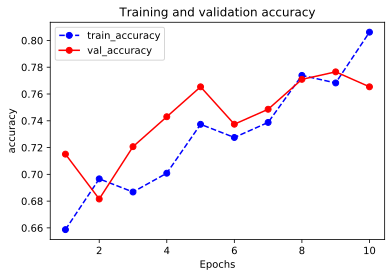

In [9]:
#================================================================================
# 5. Evaluating the model
#================================================================================
printlog("step5: eval model...")

model.summary()


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    
plot_metric(history,"accuracy")